<a href="https://colab.research.google.com/github/TAYAyuki/PyTorch_practice/blob/master/PyTorch_CNN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データのロード・下処理

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

CIFAR10 : 60000 \
訓練 50000    テスト 10000

CIFAR10(root = , train =  , download = , transform = )


> root : データが保存されているところ\
train : True -> 50000データをロード , False -> 10000データをロード\
download : True -> rootに位置にデータ保存\
transform : transformに書かれている下処理をロードした後に実行してくれる


DataLoader(train(test)set, batch_size= , shuffle= num_workers= )


> train(test)set :  データセット\
batch_size : 1バッチサイズごとにいくつにサンプルをロードするか\
shuffle :  1エポックごとにデータがシャッフルされる\
num_workers : データをロードするのにいくつのサブプロセスを使用するか(デフォルトは0でメインプロセスのみを使う)\
sampler : 自分でサンプリングするものを決めたいとき指定する.ただしshuffleはFalseにしなければいけない

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(), #ToTensor() : テンソル型に変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize(RGBの平均, 偏差)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


WeightedRandomSampler(重みの配列, サンプリングする回数, replacement)\
replacement\
 TRUE -> サンプリングして取り出した画像を再び戻してサンプリングする\
 FALSE -> 取り出した画像を再び戻さずにサンプリングする
 
 np.transpose(配列, (配列の並び替えたい順序)) : (配列の並び替えたい順序)は(1,2,0)だと元の配列の1番目 2番目 0番目の順にする

images shape : torch.Size([4, 3, 32, 32]) <- (画像の枚数, RGB, 縦, 横)
labels shape : torch.Size([4])
images の値が-1から1になっている
npimg shape : (3, 36, 138)  <- (RGB, 縦 32 + 2(枠)*2, 横 32*4 + 2(枠)*5)


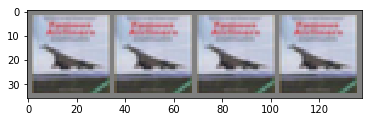

In [25]:
import numpy as np
import matplotlib.pyplot as plt
# 一つの画像だけ1の重みベクトルを作る．
weights = np.zeros(10000) #1*10000の配列を0で埋める(テストデータの数10000)
weights[3] = 1. #テストで取り出したいデータの重みを1にする. この場合3000番
num_samples = 4 # サンプリングする回数

# WeightedRandomSamplerを試す．
my_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples, replacement=True)
my_testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2, sampler=my_sampler)

#1バッチ分を取り出したい時iter()で囲ってから next()で呼び出す
my_testiter = iter(my_testloader)
images, labels = my_testiter.next()

print("images shape : "+str(images.shape)+ " <- (画像の枚数, RGB, 縦, 横)")
print("labels shape : "+str(labels.shape))
print("images の値が-1から1になっている")

# imshow関数は次に説明するけどちょっと先走って使う．
def imshow(img):
    img = img / 2 + 0.5     # unnormalize 2で割って範囲を-0.5から0.5にして+0.5することで0から1の範囲にしている
    npimg = img.numpy()  #torch.Tensor型 から numpy.ndarray型に変更
    print("npimg shape : "+str(npimg.shape)+"  <- (RGB, 縦 32 + 2(枠)*2, 横 32*4 + 2(枠)*5)" )  
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #imshowに渡すために(縦, 横, RGB)の順に並んでいなくてはならないためindexで順序を並び替え
    
imshow(torchvision.utils.make_grid(images)) #複数の画像を横に並べる paddingのデフォルトが2でimagesのshapeの 画像の枚数 がなくなる

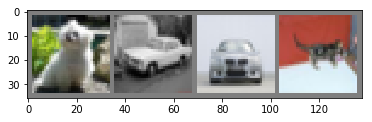

            dog              car              car              cat


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 訓練データをランダムに取得
dataiter = iter(trainloader) 
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print('  '.join('%15s' % classes[labels[j]] for j in range(4)))  #15文字分の中で右寄せ

# モデル

Variable : torch.Tensor をwrapして勾配を格納できるようにする\
.data にテンソルが格納されていて、.grad に勾配が格納されている

> a = torch.FloatTensor([1])\
a2 = Variable(a)\
print(type(a)) # <class 'torch.FloatTensor'>\
print(type(a2)) # <class 'torch.autograd.variable.Variable'>\
print(type(a2.data)) # <class 'torch.FloatTensor'>\
a.numpy() -> [1]\
a2.data.numpy() -> [1]\
a2.grad -> None\
a2.grad = Variable(torch.FloatTensor([100]))\
a2.grad -> Variable containing: 100


In [0]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
